In [1]:
# @title Setup


!pip install openai geoclip torch

import torch, base64
from openai import OpenAI
from geoclip import GeoCLIP
from google.colab import files
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Check if CUDA is available
if not torch.cuda.is_available():
    print("This notebook runs faster if a GPU is enabled. Please ensure that you have selected GPU as the Hardware accelerator in the Runtime settings.")
    cuda_av = False
else:
    print("CUDA is available. You're good to go!")
    cuda_av = True

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Saving 103385471_f54982a801_29_73293249@N00.jpeg to 103385471_f54982a801_29_73293249@N00 (1).jpeg
Image 103385471_f54982a801_29_73293249@N00 (1).jpeg uploaded successfully!


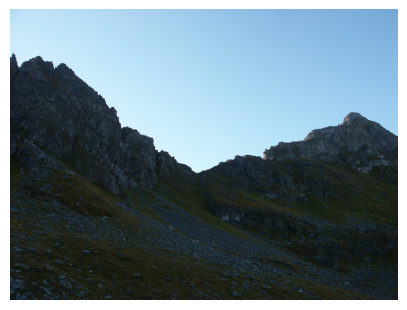

In [50]:
# @title Upload image for analysis:

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

uploaded = files.upload()

if uploaded:
    # Read Image
    image_name = next(iter(uploaded))
    image_path = BytesIO(uploaded[image_name])

    print(f"Image {image_name} uploaded successfully!")

    b64_image = encode_image(image_name)

    # Display the uploaded image
    image = Image.open(image_path)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
else:
    print("No image uploaded. Please try again.")

In [40]:
# @title Put your OpenAI key here to access GPT-4o and GPT-3.5
openaikey = "" # @param {"type":"string","placeholder":"KEY HERE"}

class OpenAIKey(Exception):
    pass

client = OpenAI(api_key=openaikey)

try:
  client.models.list()
except:
  print("Invalid OpenAI key!")

In [45]:
# @title Choose which model(s) to run and image quality:
models = "GPT-4o AND GPT-4o-mini" # @param ["GPT-4o only","GPT-4o-mini only","GPT-4o AND GPT-4o-mini"]
image_quality_to_use = "low" # @param ["high","low"]

In [29]:
from geopy.geocoders import Nominatim

#@title Running GEOCLIP inference

# GeoCLIP
from geoclip import GeoCLIP
geolocator = Nominatim(user_agent="GEOCLIPOSINT")
clip_addresses = []

import logging
logging.getLogger('OSMPythonTools').setLevel(logging.ERROR)

model = GeoCLIP().to("cuda")
print("===========================")
print("GeoCLIP has been loaded! 🎉")
print("===========================")
top_pred_gps, top_pred_prob = model.predict(image_name, top_k=50)
# Display the top 5 GPS predictions
print("Top 5 GPS Predictions 📍")
print("========================")
x = 0
for coords in top_pred_gps:
    clip_addresses.append((geolocator.reverse(str(str(float(coords[0])) + ", " + str(float(coords[1]))), language='en', zoom=8).address, top_pred_prob[x]))
    x += 1
for i in range(5):
    lat, lon = top_pred_gps[i]
    print(f"Prediction {i+1} Coordinates: ({lat:.6f}, {lon:.6f}) - Address: {clip_addresses[i][0]} - Probability: {top_pred_prob[i]:.6f}")


GeoCLIP has been loaded! 🎉
Top 5 GPS Predictions 📍
Prediction 1 Coordinates: (68.203896, 13.479012) - Address: Nordland, Norway - Probability: 0.065515
Prediction 2 Coordinates: (66.701363, 13.732452) - Address: Nordland, Norway - Probability: 0.032794
Prediction 3 Coordinates: (66.535141, 12.968673) - Address: Nordland, Norway - Probability: 0.029294
Prediction 4 Coordinates: (66.815994, 13.557128) - Address: Nordland, Norway - Probability: 0.028737
Prediction 5 Coordinates: (67.900139, 18.321737) - Address: Norrbotten County, Sweden - Probability: 0.024783


In [51]:
# @title Run GPT(s)


prompt = "Guess where this image was taken, get creative. Here’s some AI-generated addresses that could be wrong to get you started. Choose the best out of these if you’re uncertain about the image:\n"

b64_image2 = "data:image/jpeg;base64," + b64_image

x = 0
for clip_address in clip_addresses[:5]:
  prompt = prompt + "\n" + str(x + 1) + ". " + clip_address[0]
  x += 1

if models == "GPT-4o only":
  response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {
      "role": "system",
      "content": [
        {
          "type": "text",
          "text": "You are an Image OSINT Investigator. I will provide you with an image and it’s your job to determine where it was taken. By the end of your investigation you have to have at least a rough guess of the image’s location. DECIDE ON ONE FINAL LOCATION, EVEN IF IT’S WRONG, JUST GUESS."
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "type": "image_url",
          "image_url": {
            "url": b64_image2,
            "detail": image_quality_to_use
          }
        }
      ]
    }
  ],
  temperature=1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
  ).choices[0].message.content
elif models == "GPT-4o-mini only":
  response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "system",
      "content": [
        {
          "type": "text",
          "text": "You are an Image OSINT Investigator. I will provide you with an image and it’s your job to determine where it was taken. By the end of your investigation you have to have at least a rough guess of the image’s location. DECIDE ON ONE FINAL LOCATION, EVEN IF IT’S WRONG, JUST GUESS."
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "type": "image_url",
          "image_url": {
            "url": b64_image2,
            "detail": image_quality_to_use
          }
        }
      ]
    }
  ],
  temperature=1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
  ).choices[0].message.content
else:
  response = [client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "system",
      "content": [
        {
          "type": "text",
          "text": "You are an Image OSINT Investigator. I will provide you with an image and it’s your job to determine where it was taken. By the end of your investigation you have to have at least a rough guess of the image’s location. DECIDE ON ONE FINAL LOCATION, EVEN IF IT’S WRONG, JUST GUESS."
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "type": "image_url",
          "image_url": {
            "url": b64_image2,
            "detail": image_quality_to_use
          }
        }
      ]
    }
  ],
  temperature=1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
  ).choices[0].message.content, client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {
      "role": "system",
      "content": [
        {
          "type": "text",
          "text": "You are an Image OSINT Investigator. I will provide you with an image and it’s your job to determine where it was taken. By the end of your investigation you have to have at least a rough guess of the image’s location. DECIDE ON ONE FINAL LOCATION, EVEN IF IT’S WRONG, JUST GUESS."
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "type": "image_url",
          "image_url": {
            "url": b64_image2,
            "detail": image_quality_to_use
          }
        }
      ]
    }
  ],
  temperature=1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
  ).choices[0].message.content]

In [52]:
# @title Show outputs


if type(response) == str:
  print(models + ", responded with:")
  print(response)
elif type(response) == list:
  print("GPT-4o-mini" + ", responded with:")
  print(response[0])

  print("\n")

  print("GPT-4o" + ", responded with:")
  print(response[1])

GPT-4o-mini , responded with:
Based on the mountainous terrain and natural landscape in the image, I would guess that this location is in **Nordland, Norway**. The rugged hills and clear sky are characteristic of the scenery found in that region.


GPT-4o, responded with:
Given the image of rugged, rocky mountains with some greenery and clear sky, it resembles the natural landscapes commonly found in northern Europe. Considering the AI-generated addresses you provided, the most plausible location seems to be Nordland, Norway. Nordland is known for its dramatic mountain landscapes and natural beauty.

Therefore, my guess is that this image was taken in Nordland, Norway.
